In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from tqdm.auto import tqdm
import aa_test as aa

# Задача

- A/A тестирование мобильного приложения
- Проверить корректность работы системы сплитования
- Если система сплитования работает некорректно, определить причины

# Данные

In [2]:
# Загрузка
df = pd.read_csv('hw_aa.csv', sep=';')
# Преобразование
df = df.drop('Unnamed: 0', axis=1).rename(columns={'experimentVariant': 'split'})
df

,uid,split,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


- split - группа пользователей после сплитирования
- version - версия приложения
- purchase - факт покупки

### Разведочный анализ

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   uid       127018 non-null  object
 1   split     127018 non-null  int64 
 2   version   127018 non-null  object
 3   purchase  127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


In [4]:
df.split.value_counts()

1    63916
0    63102
Name: split, dtype: int64

Объёмы экспериментальных групп сравнимы

In [5]:
df.version.unique()

array(['v2.8.0', 'v2.9.0', 'v3.7.4.0', 'v3.8.0.0'], dtype=object)

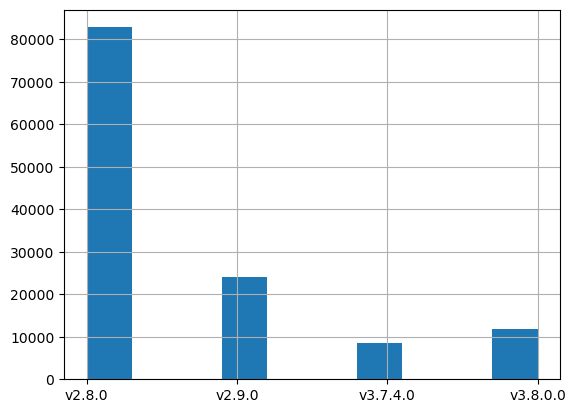

In [6]:
df.version.hist();

Популярность версий различается

In [7]:
London bikesdf.purchase.value_counts()

0    122104
1      4914
Name: purchase, dtype: int64

Заказов довольно мало

---------

# Проверка функции на синтетических данных

*Для понимания возможности использования t-теста, как основы синтетических тестов, в рамках задачи (данные с распределением Бернулли)

Определение параметров распределения Бернулли по имеющимся данным

In [45]:
df.split.value_counts()

1    63916
0    63102
Name: split, dtype: int64

In [46]:
# Количество действий для выборок
s0_size = df.split.value_counts()[0]
s1_size = df.split.value_counts()[1]
print(f'sample sizes: ({s0_size}; {s1_size})')

sample sizes: (63102; 63916)


#### Одинаковые выборки

In [47]:
# Вероятность заказа обобщённая
success_probability = df.purchase.value_counts()[1] / df.purchase.value_counts()[0]
success_probability

0.04024438183843281

In [74]:
# Создание выборок
s0 = pd.Series(ss.bernoulli.rvs(
    success_probability,
    size=s0_size
))
s1 = pd.Series(ss.bernoulli.rvs(
    success_probability,
    size=s1_size
))

  0%|          | 0/5000 [00:00<?, ?it/s]

min sample size: 63102
synthetic subsample size: 6310


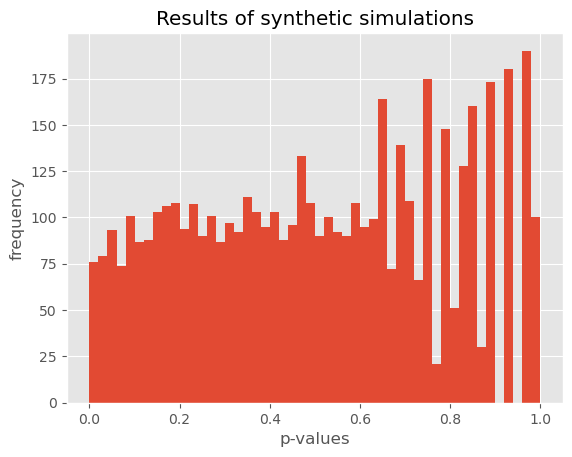

FPR: 0.0392
fpr_ok: True


True

In [75]:
aa.synth_test(s0, s1)

_Вероятность ошибки 1го рода_

In [50]:
N = 300  # Количество синтетических тестов

In [51]:
fpr_ok_statistic = []
for i in tqdm(range(N)):
    s0 = pd.Series(ss.bernoulli.rvs(
        success_probability,
        size=s0_size
    ))
    s1 = pd.Series(ss.bernoulli.rvs(
        success_probability,
        size=s1_size
    ))

    fpr_ok_statistic.append(aa.synth_test(
        s0, 
        s1,
        print_info=False
    ))

err_rate = (N - sum(fpr_ok_statistic)) / N
print(f'err_rate = {round(err_rate*100, 2)} %')

  0%|          | 0/300 [00:00<?, ?it/s]

err_rate = 12.33 %


#### Отличающиеся выборки

In [52]:
df_statistic = (
    df.groupby(['split', 'purchase']).uid.count()
)
df_statistic

split  purchase
0      0           61591
       1            1511
1      0           60513
       1            3403
Name: uid, dtype: int64

Вероятности заказа

In [53]:
split = 0
s0_success_probability = df_statistic[split, 1] / df_statistic[split, 0]
s0_success_probability

0.024532805117630823

In [54]:
split = 1
s1_success_probability = df_statistic[split, 1] / df_statistic[split, 0]
s1_success_probability

0.056235850147902104

In [55]:
# Создание выборок
s0 = pd.Series(ss.bernoulli.rvs(
    s0_success_probability,
    size=s0_size
))
s1 = pd.Series(ss.bernoulli.rvs(
    s1_success_probability,
    size=s1_size
))

  0%|          | 0/5000 [00:00<?, ?it/s]

min sample size: 63102
synthetic subsample size: 6310


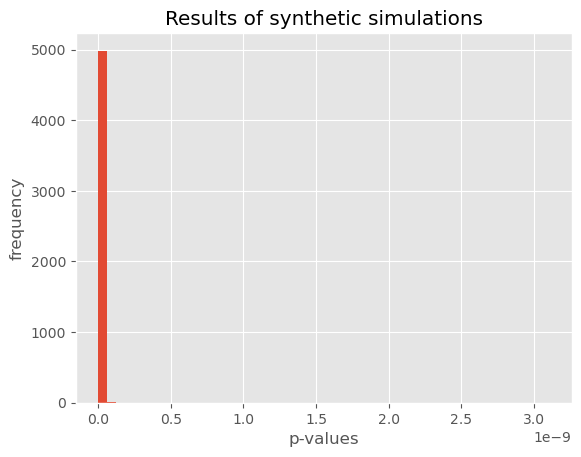

FPR: 1.0
fpr_ok: False


False

In [56]:
aa.synth_test(s0, s1)

_Вероятность ошибки 2го рода_

In [57]:
fpr_ok_statistic = []
for i in tqdm(range(N)):
    s0 = pd.Series(ss.bernoulli.rvs(
        s0_success_probability,
        size=s0_size
    ))
    s1 = pd.Series(ss.bernoulli.rvs(
        s1_success_probability,
        size=s1_size
    ))

    fpr_ok_statistic.append(aa.synth_test(
        s0, 
        s1,
        print_info=False
    ))

err_rate = sum(fpr_ok_statistic) / N
print(f'err_rate = {round(err_rate*100, 2)} %')

  0%|          | 0/300 [00:00<?, ?it/s]

err_rate = 0.0 %


----------

# Решение

### Проверка корректности работы системы сплитования

In [8]:
A1_df = df.query('split == 0')
A2_df = df.query('split == 1')

  0%|          | 0/5000 [00:00<?, ?it/s]

min sample size: 63102
synthetic subsample size: 6310


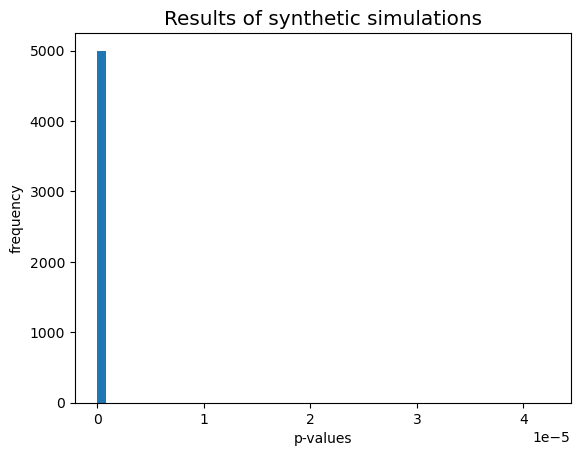

FPR: 1.0
fpr_ok: False


False

In [9]:
aa.synth_test(A1_df.purchase, A2_df.purchase)

FPR > 0.05 => выборки отличаются

#### Вывод: система сплитования работает некорректно

### Поиск причин некорректного формирования выборок

In [10]:
df.head()

,uid,split,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


_CTR по выборкам_

In [11]:
(df.groupby('split', as_index=False).purchase.mean()
 .rename(columns={'purchase': 'ctr'})
)


,split,ctr
0,0,0.023945
1,1,0.053242


=> CTR отличается в ~2 раза

_Детализация CTR по версиям_

In [12]:
df_ctr = (
    df.groupby(['split', 'version'], as_index=False).purchase.mean()
    .rename(columns={'purchase': 'ctr'})
)
df_ctr

,split,version,ctr
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


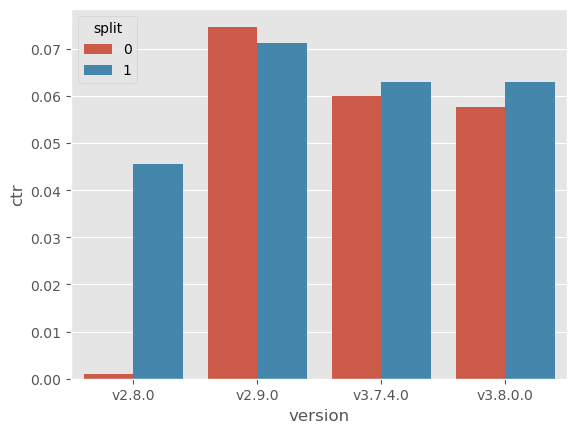

In [13]:
sns.barplot(data=df_ctr, x='version', y='ctr', hue='split');

=> Для версии 2.8.0 CTR между группами значительно отличается

In [15]:
df.groupby('version').uid.count().sort_values(ascending=False)

version
v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: uid, dtype: int64

При этом на этой версии сидит больше всего пользователей

_Проверка, что поломка именно в версии_

  0%|          | 0/5000 [00:00<?, ?it/s]

min sample size: 21819
synthetic subsample size: 2182


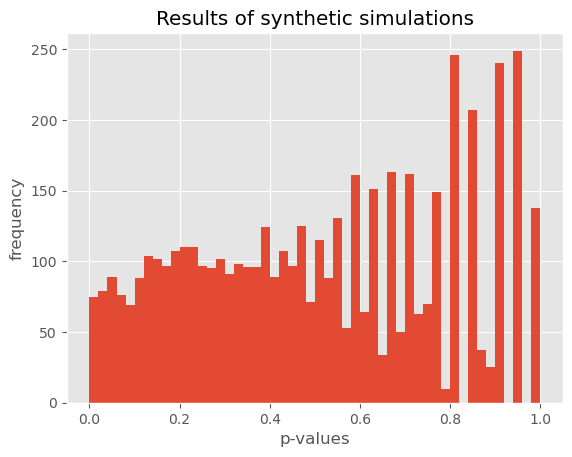

FPR: 0.038
fpr_ok: True


True

In [18]:
fixed_df = df.query('version != "v2.8.0"')

aa.synth_test(
    fixed_df.query('split == 0').purchase, 
    fixed_df.query('split == 1').purchase
)

=> действительно, поломка системы сплитования локализована в версии приложения v2.8.0

_Поиск более подробной информации_

In [19]:
anomaly_version_df = df.query('version == "v2.8.0"').sort_values(['split', 'uid'])
anomaly_version_df

,uid,split,version,purchase
84413,00029153d12ae1c9abe59c17ff2e0895,0,v2.8.0,0
36491,0002ac0d783338cfeab0b2bdbd872cda,0,v2.8.0,0
20073,00053f5e11d1fe4e49a221165b39abc9,0,v2.8.0,0
70696,00056c20eb5a029583db75506953f1d9,0,v2.8.0,0
83109,00063cb5da1826febf178b669eea3250,0,v2.8.0,0
...,...,...,...,...
40339,fff8db9478d2fd72df65a67ee6b62f67,1,v2.8.0,0
86908,fffae68750a8bd5e6ba46b25ce7030de,1,v2.8.0,1
113894,fffc797556611242e316e22cd5743f3d,1,v2.8.0,0
30524,fffe9f664c2ddba4a37bcd35936c7422,1,v2.8.0,0


In [20]:
anomaly_version_df.groupby('split', as_index=False).uid.count()

,split,uid
0,0,41283
1,1,41552


На этой версии группы ~ равного объёма

In [21]:
anomaly_version_df.groupby('split', as_index=False).head().set_index('split').uid.to_frame()

,uid
split,
0,00029153d12ae1c9abe59c17ff2e0895
0,0002ac0d783338cfeab0b2bdbd872cda
0,00053f5e11d1fe4e49a221165b39abc9
0,00056c20eb5a029583db75506953f1d9
0,00063cb5da1826febf178b669eea3250
1,000053b1e684c9e7ea73727b2238ce18
1,0004289ee1c7b8b08c77e19878106ae3
1,0004d0b59e19461ff126e3a08a814c33
1,0006aabe0ba47a35c0b0bf6596f85159


Закономерности в распределении первых id обеих групп не замечено

In [28]:
anomaly_version_df.groupby('split', as_index=False).tail().set_index('split').uid.to_frame()


,uid
split,
0,fff8406e7b47fcdfea71e0e12b74b0ec
0,fffcc1a3964b4ad665fa2f07d7bfd086
0,fffdb2ba4cfd956639195cde010f6210
0,fffe56994e6be696722539f962415cd2
0,fffee5badc626a2ab8086120712e5639
1,fff8db9478d2fd72df65a67ee6b62f67
1,fffae68750a8bd5e6ba46b25ce7030de
1,fffc797556611242e316e22cd5743f3d
1,fffe9f664c2ddba4a37bcd35936c7422


Закономерности в распределении последних id обеих групп не замечено

In [22]:
av_df_len = len(anomaly_version_df)
anomaly_version_df.sort_values('uid').head(round(av_df_len / 2)).split.mean()

0.5004828818388141

id в лексографическом порядке поделились 50/50 => проблемы тут, скорее всего, нет

### 4) Выводы

- группы для дальнейшего тестирования сформированны некорректно
- имеется значительное отличие групп в разрезе версии 2.8.0 по CTR
- причём эта версия наиболее популярна среди пользователей, так что отличиями пренебрегать нельзя
- идентификаторы uid для v2.8.0 распределены по группам в случайном порядке (=> проблема не в этом)
- для определения причины некорректной работы необходимо больше данных

Inspired by: KCM7L10

### Идеи для улучшения 
- использовать statsmodels.stats.proportion.proportions_ztest
- автодетализация причины отличия выборок (узазать столбец, по которому градации будут сравниваться между группами)
- для автодетализации попробоват Хи-квадрат тест